In [1]:
import pyedflib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bids import BIDSLayout
from multiprocessing.pool import Pool
from functools import partial
import scipy
import scipy.io as sio
import scipy.fftpack
import scipy.signal
import copy
import os
from sklearn.metrics import mean_squared_error

## PSD

In [5]:
locations_tsv_layout = BIDSLayout('/home/mcesped/scratch/code/sEEGPrep/Results/run_all/bids', validate = False)

In [6]:
locations_tsv_layout.get_subjects()

['104', '081', '079', '078', '097', '086', '090', '084']

In [7]:
locations_tsv_files = locations_tsv_layout.get(extension='tsv', suffix='space', return_type='filename')

In [8]:
locations_tsv_files[0:10]

['/home/mcesped/scratch/code/sEEGPrep/Results/run_all/bids/sub-078/ses-002/ieeg/sub-078_ses-002_task-full_run-01_regions_native_space.tsv',
 '/home/mcesped/scratch/code/sEEGPrep/Results/run_all/bids/sub-078/ses-004/ieeg/sub-078_ses-004_task-full_run-01_regions_native_space.tsv',
 '/home/mcesped/scratch/code/sEEGPrep/Results/run_all/bids/sub-078/ses-005/ieeg/sub-078_ses-005_task-full_run-01_regions_native_space.tsv',
 '/home/mcesped/scratch/code/sEEGPrep/Results/run_all/bids/sub-078/ses-006/ieeg/sub-078_ses-006_task-full_run-02_regions_native_space.tsv',
 '/home/mcesped/scratch/code/sEEGPrep/Results/run_all/bids/sub-078/ses-007/ieeg/sub-078_ses-007_task-full_run-02_regions_native_space.tsv',
 '/home/mcesped/scratch/code/sEEGPrep/Results/run_all/bids/sub-078/ses-008/ieeg/sub-078_ses-008_task-full_run-01_regions_native_space.tsv',
 '/home/mcesped/scratch/code/sEEGPrep/Results/run_all/bids/sub-078/ses-010/ieeg/sub-078_ses-010_task-full_run-01_regions_native_space.tsv',
 '/home/mcesped/scra

In [9]:
edf_files_layout = BIDSLayout('/home/mcesped/scratch/code/sEEGPrep/Results/run_all/bids', validate=False)

In [10]:
edf_files_layout.get_subjects()

['104', '081', '079', '078', '097', '086', '090', '084']

In [11]:
edf_files = edf_files_layout.get(extension='edf', suffix='clean', return_type='filename')
edf_files[0:10]

['/home/mcesped/scratch/code/sEEGPrep/Results/run_all/bids/sub-078/ses-002/ieeg/sub-078_ses-002_task-full_run-01_clean.edf',
 '/home/mcesped/scratch/code/sEEGPrep/Results/run_all/bids/sub-078/ses-004/ieeg/sub-078_ses-004_task-full_run-01_clean.edf',
 '/home/mcesped/scratch/code/sEEGPrep/Results/run_all/bids/sub-078/ses-005/ieeg/sub-078_ses-005_task-full_run-01_clean.edf',
 '/home/mcesped/scratch/code/sEEGPrep/Results/run_all/bids/sub-078/ses-006/ieeg/sub-078_ses-006_task-full_run-02_clean.edf',
 '/home/mcesped/scratch/code/sEEGPrep/Results/run_all/bids/sub-078/ses-007/ieeg/sub-078_ses-007_task-full_run-02_clean.edf',
 '/home/mcesped/scratch/code/sEEGPrep/Results/run_all/bids/sub-078/ses-008/ieeg/sub-078_ses-008_task-full_run-01_clean.edf',
 '/home/mcesped/scratch/code/sEEGPrep/Results/run_all/bids/sub-078/ses-010/ieeg/sub-078_ses-010_task-full_run-01_clean.edf',
 '/home/mcesped/scratch/code/sEEGPrep/Results/run_all/bids/sub-078/ses-011/ieeg/sub-078_ses-011_task-full_run-01_clean.edf',


In [9]:
df_test = pd.read_csv(locations_tsv_files[0], sep='\t')
df_test.head()

type    label        x        y       z group  Label ID  \
0  SEEGA  LAHc1-2 -21.0290  16.5070  31.532  LAHc        17   
1  SEEGA  LAHc2-3 -25.7220  16.5770  33.091  LAHc        17   
2  SEEGA  LAHc3-4 -30.4895  16.6175  34.273  LAHc        17   
3  SEEGA  LAHc4-5 -35.2850  16.7270  35.260  LAHc         2   
4  SEEGA  LAHc5-6 -40.1380  16.7135  36.183  LAHc         2   

                        Label    R    G    B  
0            Left-Hippocampus  220  216   20  
1            Left-Hippocampus  220  216   20  
2            Left-Hippocampus  220  216   20  
3  Left-Cerebral-White-Matter  245  245  245  
4  Left-Cerebral-White-Matter  245  245  245

In [10]:
df_test['Region']=df_test['Label'].str.replace('Left-', '')
df_test['Region']=df_test['Region'].str.replace('Right-', '')
df_test

type       label        x        y        z   group  Label ID  \
0    SEEGA     LAHc1-2 -21.0290  16.5070  31.5320    LAHc        17   
1    SEEGA     LAHc2-3 -25.7220  16.5770  33.0910    LAHc        17   
2    SEEGA     LAHc3-4 -30.4895  16.6175  34.2730    LAHc        17   
3    SEEGA     LAHc4-5 -35.2850  16.7270  35.2600    LAHc         2   
4    SEEGA     LAHc5-6 -40.1380  16.7135  36.1830    LAHc         2   
..     ...         ...      ...      ...      ...     ...       ...   
103  SEEGA   RLOcLg5-6  30.5915 -27.0690  46.7875  RLOcLg        41   
104  SEEGA   RLOcLg6-7  33.5495 -30.7380  47.7140  RLOcLg        41   
105  SEEGA   RLOcLg7-8  36.3515 -34.5695  48.4290  RLOcLg        41   
106  SEEGA   RLOcLg8-9  39.4170 -38.3700  49.4085  RLOcLg        41   
107  SEEGA  RLOcLg9-10  42.7525 -41.9625  50.5725  RLOcLg        41   

                           Label    R    G    B                 Region  
0               Left-Hippocampus  220  216   20            Hippocampus  
1               Left-Hippocampus  220  216   20            Hippocampus  
2               Left-Hippocampus  220  216   20            Hippocampus  
3     Left-Cerebral-White-Matter  245  245  245  Cerebral-White-Matter  
4     Left-Cerebral-White-Matter  245  245  245  Cerebral-White-Matter  
..                           ...  ...  ...  ...                    ...  
103  Right-Cerebral-White-Matter  245  245  245  Cerebral-White-Matter  
104  Right-Cerebral-White-Matter  245  245  245  Cerebral-White-Matter  
105  Right-Cerebral-White-Matter  245  245  245  Cerebral-White-Matter  
106  Right-Cerebral-White-Matter  245  245  245  Cerebral-White-Matter  
107  Right-Cerebral-White-Matter  245  245  245  Cerebral-White-Matter  

[108 rows x 12 columns]

In [11]:
non_white_matter_unknown_bool = df_test['Label'].str.contains('White-Matter|Unknown', case=False, regex=True)==False
filtered_df = df_test.loc[non_white_matter_unknown_bool]
filtered_df.head()

type     label        x        y        z  group  Label ID  \
0   SEEGA   LAHc1-2 -21.0290  16.5070  31.5320   LAHc        17   
1   SEEGA   LAHc2-3 -25.7220  16.5770  33.0910   LAHc        17   
2   SEEGA   LAHc3-4 -30.4895  16.6175  34.2730   LAHc        17   
18  SEEGA  LAOFr1-2  -9.4585  54.7580  18.2755  LAOFr      1014   
19  SEEGA  LAOFr2-3 -13.7695  56.6895  19.5540  LAOFr      1012   

                          Label    R    G   B                       Region  
0              Left-Hippocampus  220  216  20                  Hippocampus  
1              Left-Hippocampus  220  216  20                  Hippocampus  
2              Left-Hippocampus  220  216  20                  Hippocampus  
18   ctx-lh-medialorbitofrontal  200   35  75   ctx-lh-medialorbitofrontal  
19  ctx-lh-lateralorbitofrontal   35   75  50  ctx-lh-lateralorbitofrontal

In [12]:
unique_labels = set(filtered_df['Label'].str.replace('Left-', '').str.replace('Right-', ''))
unique_labels

{'Amygdala',
 'Hippocampus',
 'ctx-lh-insula',
 'ctx-lh-lateralorbitofrontal',
 'ctx-lh-medialorbitofrontal',
 'ctx-lh-middletemporal',
 'ctx-lh-parstriangularis',
 'ctx-lh-superiortemporal',
 'ctx-rh-lingual'}

In [13]:
regions_dict = {}
for label in unique_labels:
    if label in regions_dict.keys():
        regions_dict[label] = regions_dict[label]+filtered_df[filtered_df['Region']==label].index.values.tolist()
    else:
        regions_dict[label] = filtered_df.loc[filtered_df['Region']==label,'label'].values.tolist()

In [14]:
regions_dict

{'ctx-lh-insula': ['LMIn1-2',
  'LMIn2-3',
  'LMIn3-4',
  'LMIn4-5',
  'LPIn1-2',
  'LPIn2-3',
  'LPIn3-4',
  'LPIn4-5',
  'LPIn9-10'],
 'ctx-rh-lingual': ['RLOcLg1-2'],
 'ctx-lh-lateralorbitofrontal': ['LAOFr2-3',
  'LAOFr3-4',
  'LAOFr4-5',
  'LAOFr5-6',
  'LPOFrL2-3'],
 'ctx-lh-parstriangularis': ['LPOFrL8-9'],
 'Amygdala': ['LAm2-3', 'LAm3-4'],
 'ctx-lh-superiortemporal': ['LAm4-5', 'LAm8-9'],
 'Hippocampus': ['LAHc1-2',
  'LAHc2-3',
  'LAHc3-4',
  'LMHc1-2',
  'LMHc2-3',
  'LMHc3-4',
  'RAHc1-2',
  'RAHc2-3',
  'RAHc3-4'],
 'ctx-lh-medialorbitofrontal': ['LAOFr1-2', 'LPOFrL1-2'],
 'ctx-lh-middletemporal': ['LAm9-10', 'LMHc8-9', 'LMHc9-10']}

In [25]:
signals_region.keys()

dict_keys(['Amygdala'])

In [26]:
len(signals_region['Amygdala'])

215

In [3]:
def welchMethod(data, srate):
    # create Hann window
    winsize = int( 2.0*srate ) # 2-second window
    hannw = .5 - np.cos(2*np.pi*np.linspace(0,1,winsize))/2

    # number of FFT points (frequency resolution)
    spectres = 0.01; # Hz
    nfft = int(srate/spectres)
    # print('hihi')
    # Apply Welch method
    f, welchpow = scipy.signal.welch(data,fs=srate,window=hannw,
                                    nperseg=winsize,noverlap=winsize/2,nfft=nfft, scaling='density')
    # print(welchpow.shape)
    # Normalizing
    if welchpow.ndim > 1:
        welchpow = np.divide(welchpow, np.sqrt(np.sum(welchpow**2, axis=1)).reshape(welchpow.shape[0],1))
    else:
        welchpow = np.divide(welchpow, np.sqrt(np.sum(welchpow**2)))
    return f, welchpow

In [103]:
def extract_channel_data(chn_label, edf_file):
    edf_in = pyedflib.EdfReader(edf_file)
    # Get labels from original edf file
    channels_labels = edf_in.getSignalLabels()
    # Get channel id
    chn_id = channels_labels.index(chn_label)
    # Get the data
    signal = edf_in.readSignal(chn_id)
    edf_in.close()
    f, psd = welchMethod(signal, 200)
    return f, psd, chn_label

In [4]:
def plotAllChannels(freq, welchpow, out_path=None, output=False, show_fig = False, ax=None):
    x_val = [0.5, 4, 8, 13, 30, 80]
    default_x_ticks = range(len(x_val))
    if ax == None:
        fig, ax = plt.subplots()
    ax.semilogx(freq,welchpow)
    ax.semilogx([4, 4], [0, 0.12], '--k')
    ax.semilogx([8, 8], [0, 0.12], '--k')
    ax.semilogx([13, 13], [0, 0.12], '--k')
    ax.semilogx([30, 30], [0, 0.12], '--k')
    ax.set_xticks(x_val)
    ax.set_xticklabels(x_val)
    ax.set_xlim([0.5,80])
    ax.set_ylim([0, 0.12])
    ax.set_xlabel('frequency [Hz]')
    ax.set_ylabel('Power')
    if output:
        fig.savefig(out_path)
    if show_fig:
        plt.show()
    elif show_fig == 'Close':
        plt.close()

In [5]:
def plotPaperFigures(freq, welchpow, out_path=None, output=False, show_fig=False, ax=None):
    # welchpow: n_chans x n_samples
    # Get median:
    median_welchpow = np.median(welchpow, axis=0)
    # Get std
    n_samples = welchpow.shape[1]
    std = np.zeros(n_samples)
    mean = np.zeros(n_samples)
    for i in range(n_samples):
        (mean[i], std[i]) = scipy.stats.norm.fit(welchpow[:,i].squeeze())
    # Get quartiles
    quant = np.quantile(welchpow, [0.25, 0.75], axis=0)
    # Get max and min
    max_pow = np.max(welchpow, axis=0)
    min_pow = np.min(welchpow, axis=0)

    # Plot
    x_val = [0.5, 4, 8, 13, 30, 80]
    default_x_ticks = range(len(x_val))
    if ax == None:
        fig, ax = plt.subplots()
    ax.semilogx(freq, median_welchpow, 'r')
    ax.fill_between(freq,
                    quant[0,:],
                    quant[1, :],
                    alpha=0.2, color='tab:pink')
    ax.semilogx(freq, max_pow, '--', color='tab:orange')
    ax.semilogx(freq, min_pow, '--', color='tab:orange')
    ax.semilogx([4, 4], [0, 0.12], '--k')
    ax.semilogx([8, 8], [0, 0.12], '--k')
    ax.semilogx([13, 13], [0, 0.12], '--k')
    ax.semilogx([30, 30], [0, 0.12], '--k')
    ax.set_xticks(x_val)
    ax.set_xticklabels(x_val)
    ax.set_xlim([0.5,80])
    ax.set_ylim([0, 0.12])
    ax.set_xlabel('frequency [Hz]')
    ax.set_ylabel('Power')
    # ax.set_xscale('log')
    if output:
        fig.savefig(out_path)
    if show_fig:
        plt.show()
    elif show_fig == 'Close':
        plt.close()
    return median_welchpow, mean, std

In [34]:
%%time
# Loop over files and extract info
psd_region = {}
f_regions = {}
edf_regions = {}
chn_regions = {}
for tsv, edf in zip(locations_tsv_files, edf_files):
    # Read location tsv file
    df_locations = pd.read_csv(tsv, sep='\t')
    # Add new column with the regions
    df_locations['Region']=df_locations['Label'].str.replace('Left-', '')
    df_locations['Region']=df_locations['Region'].str.replace('Right-', '')
    # Filter white-matter and unknown 
    non_white_matter_unknown_bool = df_locations['Label'].str.contains('White-Matter|Unknown', case=False, regex=True)==False
    filtered_df = df_locations.loc[non_white_matter_unknown_bool]
    # Get unique regions
    unique_labels = set(filtered_df['Region'])
    # unique_labels = ['Amygdala'] # REMOVE
    # Get regions info in dict
    for label in unique_labels:
        # Get channel labels associated to region label
        chn_list = filtered_df.loc[filtered_df['Region']==label,'label'].values.tolist()
        # Get data from edf file
        # ctx = get_context('spawn')
        with Pool(processes=4) as pool:
            # signals = pool.map(partial(extract_channel_data, edf_file=edf), chn_list)
            f, psd, chns = zip(*pool.map(partial(extract_channel_data, edf_file=edf), chn_list))
        # Convert signals to frequency domain
        # data = np.vstack(signals)
        # f, psd = welchMethod(data, 200)
        # Append to dictionary
        if label in psd_region.keys():
            psd_region[label] += psd
            edf_regions[label]+= [edf for curve in psd]
            chn_regions[label] += chns 
            f_regions[label] += f
        else:
            psd_region[label] = psd
            edf_regions[label] = [edf for curve in psd]
            chn_regions[label] = chns 
            f_regions[label] = f
        

NameError: name 'locations_tsv_files' is not defined

--Welch for every label after each iteration:
CPU times: user 5min 40s, sys: 4min 22s, total: 10min 3s
Wall time: 11min 2s

--Welch on every signal
CPU times: user 8.26 s, sys: 54.7 s, total: 1min 2s
Wall time: 5min 12s

In [13]:
len(psd_region.keys())

40

In [14]:
len(edf_regions.keys())

40

In [91]:
# Save data
out_dir = '/home/mcesped/scratch/code/HippiEEGAtlas/Results/PSD'
median_region = {}
std_region = {}
mean_region = {}
for region in psd_region.keys():
    # Extract data
    psd = np.vstack(psd_region[region])
    f = np.vstack(f_regions[region])
    # Save arrays
    # np.save(os.path.join(out_dir,f'numpy_arrays/{region}_psd.npy'), psd)
    # np.save(os.path.join(out_dir,f'numpy_arrays/{region}_f.npy'), f)
    # Plot and save all channels
    output_path = os.path.join(out_dir,f'{region}_allChan.png')
    plotAllChannels(f.T, psd.T, output_path)
    # Plot and save the median curve
    output_path = os.path.join(out_dir,f'{region}_distribution.png')
    median, mean, std = plotPaperFigures(f[0], psd, output_path)
    median_region[region] = median
    std_region[region] = std
    mean_region[region] = mean

In [16]:
psd = np.vstack(psd_region['Amygdala'])
f = np.vstack(f_regions['Amygdala'])

In [57]:
f.shape

(215, 10001)

In [50]:
psd.shape

(215, 10001)

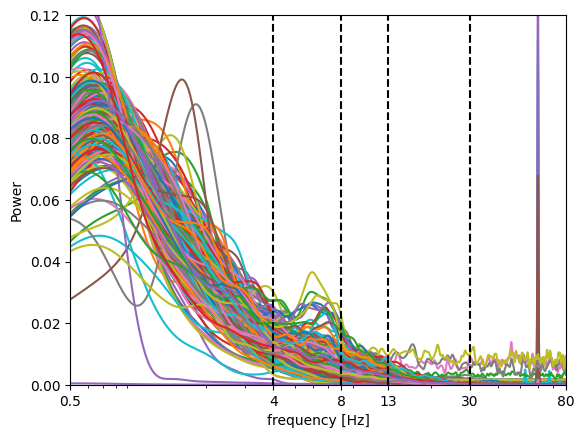

In [21]:
plotAllChannels(f.T, psd.T, show_fig=True)

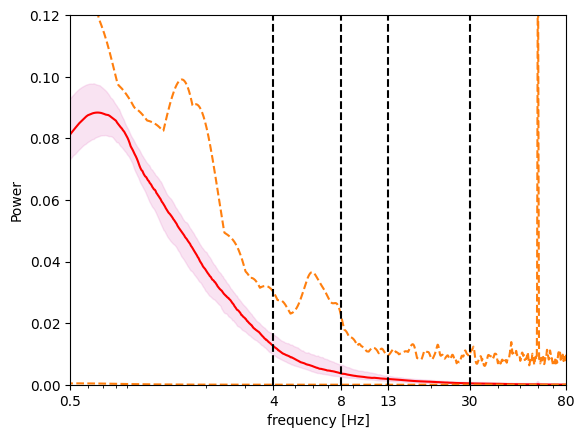

array([1.44995142e-02, 2.90367809e-02, 2.91499247e-02, ...,
       2.60398167e-06, 2.60309500e-06, 1.30139974e-06])

In [22]:
plotPaperFigures(f[0], psd, show_fig=True)


In [ ]:
del f, welchpow, data

## Compare against original

In [74]:
# Original data
# edf_files_layout2 = BIDSLayout('/home/mcesped/scratch/code/sEEGPrep/Results/run_all/work', validate=False)
edf_files_layout2 = BIDSLayout('/home/mcesped/scratch/code/sEEGPrep/Results/run_all/bids', validate=False)

In [75]:
edf_files2 = edf_files_layout2.get(subject= '079',extension='edf', suffix='clean', return_type='filename')
edf_files2

['/home/mcesped/scratch/code/sEEGPrep/Results/run_all/bids/sub-079/ses-002/ieeg/sub-079_ses-002_task-full_run-01_clean.edf',
 '/home/mcesped/scratch/code/sEEGPrep/Results/run_all/bids/sub-079/ses-003/ieeg/sub-079_ses-003_task-full_run-01_clean.edf',
 '/home/mcesped/scratch/code/sEEGPrep/Results/run_all/bids/sub-079/ses-004/ieeg/sub-079_ses-004_task-full_run-01_clean.edf',
 '/home/mcesped/scratch/code/sEEGPrep/Results/run_all/bids/sub-079/ses-005/ieeg/sub-079_ses-005_task-full_run-01_clean.edf']

In [76]:
# Loop over files and extract info
signals_region = {}
for edf in edf_files2:
    label = 'ctx-rh-parstriangularis'
    # Get channel labels associated to region label
    # chn_list = ['RPOFr9', 'RPOFr10']
    chn_list = ['RPOFr9-10']
    # Get data from edf file
    with Pool(processes=4) as pool:
        signals = pool.map(partial(extract_channel_data, edf_file=edf), chn_list)
    # Append to dictionary
    if label in signals_region.keys():
        # signals_region[label] += [signals[0]-signals[1]]
        signals_region[label] += signals
    else:
        # signals_region[label] = [signals[0]-signals[1]]
        signals_region[label] = signals

In [77]:
data = np.vstack(signals_region['ctx-rh-parstriangularis'])

In [78]:
data.shape

(4, 60200)

In [79]:
f, welchpow = welchMethod(data, 200)

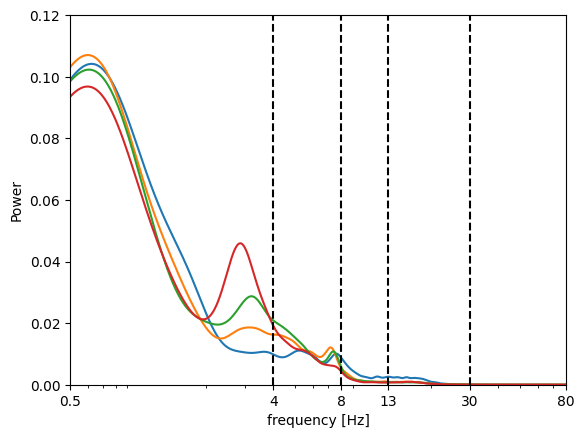

In [80]:
plotAllChannels(f, welchpow)

## Calculate error against median

In [97]:
def error_std(mean, std, y_pred):
    # Center signal
    y_centered = np.subtract(y_pred, mean)
    return np.sum(np.abs(np.divide(y_centered, std, out=np.zeros_like(y_pred), where=std!=0)))/len(std)

In [105]:
# Using the RMSE
rmse_regions_list = []
for region in psd_region.keys():
    # Extract data per signal
    for idx, psd in enumerate(psd_region[region]):
        # print(region)
        # Calculate error per freq band
        freq_bands = [0,4,8,13,30,80]
        rmse_bands = []
        for i in range(len(freq_bands)-1):
            idx0 = np.argmin(np.abs(f_regions[region][idx]-freq_bands[i]))
            idx1 = np.argmin(np.abs(f_regions[region][idx]-freq_bands[i+1]))
            rmse_bands.append(error_std(mean_region[region][idx0:idx1], std_region[region][idx0:idx1], psd[idx0:idx1].squeeze()))
        tmp_dict = {
            'Region': region,
            'Index list': idx,
            'EDF file': edf_regions[region][idx],
            'Channel': chn_regions[region][idx],
            'Error Delta': np.round(rmse_bands[0], decimals=4),
            'Error Theta': np.round(rmse_bands[1], decimals=4),
            'Error Alpha': np.round(rmse_bands[2], decimals=4),
            'Error Beta': np.round(rmse_bands[3], decimals=4),
            'Error Gamma': np.round(rmse_bands[4], decimals=4)
        }
        rmse_regions_list.append(tmp_dict)

In [106]:
rmse_regions_df = pd.DataFrame(rmse_regions_list)
rmse_regions_df.loc[rmse_regions_df['Region']=='Amygdala']

Region  Index list                                           EDF file  \
752  Amygdala           0  /home/mcesped/scratch/code/sEEGPrep/Results/ru...   
753  Amygdala           1  /home/mcesped/scratch/code/sEEGPrep/Results/ru...   
754  Amygdala           2  /home/mcesped/scratch/code/sEEGPrep/Results/ru...   
755  Amygdala           3  /home/mcesped/scratch/code/sEEGPrep/Results/ru...   
756  Amygdala           4  /home/mcesped/scratch/code/sEEGPrep/Results/ru...   
..        ...         ...                                                ...   
962  Amygdala         210  /home/mcesped/scratch/code/sEEGPrep/Results/ru...   
963  Amygdala         211  /home/mcesped/scratch/code/sEEGPrep/Results/ru...   
964  Amygdala         212  /home/mcesped/scratch/code/sEEGPrep/Results/ru...   
965  Amygdala         213  /home/mcesped/scratch/code/sEEGPrep/Results/ru...   
966  Amygdala         214  /home/mcesped/scratch/code/sEEGPrep/Results/ru...   

    Channel  Error Delta  Error Theta  Error Alpha  Error Beta  Error Gamma  
752  LAm2-3       0.7699       0.1232       0.1554      0.2313       0.3577  
753  LAm3-4       0.2787       0.1153       0.1191      0.0783       0.2086  
754  LAm2-3       0.7996       0.7372       0.3597      0.1357       0.2327  
755  LAm3-4       0.1923       0.1299       0.1855      0.2657       0.4984  
756  LAm2-3       1.0764       0.4392       0.1913      0.1071       0.2410  
..      ...          ...          ...          ...         ...          ...  
962  RAm4-5       0.5782       1.3206       0.5804      0.2294       0.3853  
963  RAm1-2       0.6399       1.1332       1.8909      0.4787       0.3344  
964  RAm2-3       0.5776       2.3841       2.6869      0.5593       0.3315  
965  RAm3-4       1.1017       0.1915       0.5137      0.1354       0.2319  
966  RAm4-5       0.3466       0.2761       0.2869      0.2829       0.3855  

[215 rows x 9 columns]

In [107]:
rmse_regions_df.iloc[rmse_regions_df.loc[rmse_regions_df['Region']=='Amygdala']['Error Delta'].idxmax()]

Region                                                  Amygdala
Index list                                                   164
EDF file       /home/mcesped/scratch/code/sEEGPrep/Results/ru...
Channel                                                   RAm3-4
Error Delta                                               4.0428
Error Theta                                               1.5807
Error Alpha                                               1.2775
Error Beta                                                0.9735
Error Gamma                                               0.6883
Name: 916, dtype: object

In [102]:
rmse_regions_df.iloc[rmse_regions_df.loc[rmse_regions_df['Region']=='Amygdala']['Error Delta'].idxmax()]['EDF file']

'/home/mcesped/scratch/code/sEEGPrep/Results/run_all/bids/sub-097/ses-019/ieeg/sub-097_ses-019_task-full_run-01_clean.edf'

In [77]:
rmse_regions_df.to_csv(os.path.join(out_dir, 'error_regions.tsv'), sep='\t')

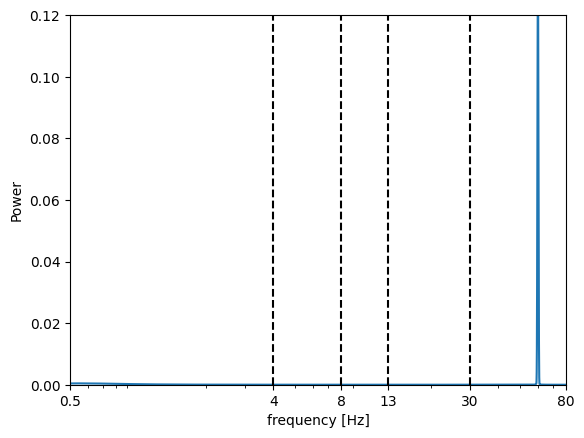

In [101]:
# Test
plotAllChannels(f_regions['Amygdala'][16],psd_region['Amygdala'][164], show_fig=True)

## Group analysis

In [206]:
# Load the data
import glob
import re
import os
import plotly.express as px
# import seaborn as sns
from sklearn.decomposition import PCA, SparsePCA, TruncatedSVD

# https://scikit-learn.org/stable/modules/manifold.html
from   sklearn.manifold import TSNE

# UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction
# https://umap-learn.readthedocs.io/en/latest/
# Import umap - Install first if not available!
!pip install umap-learn 
!pip install datashader bokeh holoviews scikit-image colorcet ipywidgets
import umap
# import umap.plot # good for plotting gigantic data

# Clustering
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import NearestNeighbors
from sklearn.mixture import GaussianMixture
import seaborn as sns
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

Looking in links: /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo/avx2, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo/generic, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/generic
Processing /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/generic/umap_learn-0.5.3+computecanada-py3-none-any.whl
Processing /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo/generic/numba-0.56.3+computecanada-cp38-cp38-linux_x86_64.whl
Processing /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/generic/pynndescent-0.5.2+computecanada-py3-none-any.whl
Processing /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo/avx2/llvmlite-0.39.1+computecanada-cp38-cp38-linux_x86_64.whl
Looking in links: /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo/avx2, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo/generic, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/generic
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2

In [50]:
!pip install yellowbrick

Looking in links: /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo/avx2, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo/generic, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/generic
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 282.6/282.6 kB 14.4 MB/s eta 0:00:00


In [6]:
parent_dir = '/home/mcesped/scratch/code/HippiEEGAtlas/Results/PSD/numpy_arrays/'
files_freq = glob.glob(parent_dir+'*_f.npy')
files_freq[0:3]

['/home/mcesped/scratch/code/HippiEEGAtlas/Results/PSD/numpy_arrays/ctx-lh-supramarginal_f.npy',
 '/home/mcesped/scratch/code/HippiEEGAtlas/Results/PSD/numpy_arrays/ctx-rh-insula_f.npy',
 '/home/mcesped/scratch/code/HippiEEGAtlas/Results/PSD/numpy_arrays/ctx-lh-middletemporal_f.npy']

In [7]:
psd_regions = {}
f_regions = {}
pattern = r'.+/(.+)_f.npy$'
for file in files_freq:
    match = re.match(pattern, file, re.IGNORECASE)
    region = match.group(1)
    # Load arrays 
    psd_regions[region] = np.load(os.path.join(parent_dir, region+'_psd.npy'))
    f_regions[region] = np.load(os.path.join(parent_dir, region+'_f.npy'))

In [8]:
psd = np.vstack(psd_regions['Amygdala'])
f = np.vstack(f_regions['Amygdala'])

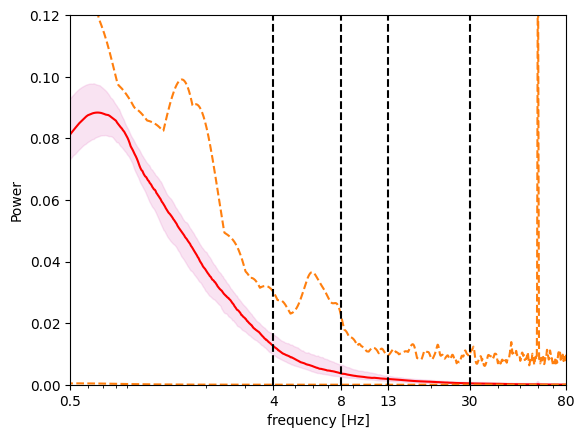

(array([1.44995142e-02, 2.90367809e-02, 2.91499247e-02, ...,
        2.60398167e-06, 2.60309500e-06, 1.30139974e-06]),
 array([0.01442568, 0.02889388, 0.0290213 , ..., 0.0002257 , 0.00022569,
        0.00011285]),
 array([0.00393468, 0.00786422, 0.00784904, ..., 0.00046506, 0.00046507,
        0.00023254]))

In [11]:
plotPaperFigures(f[0], psd, show_fig=True)

In [42]:
psd.shape # n_samples x n_features (features = freq points)

(215, 10001)

### Visualization

#### PCA

In [154]:
PCA_alg = PCA()
PCA_alg.fit(psd)

PCA()

The total explained variance using 215 components is 100.000 percent.


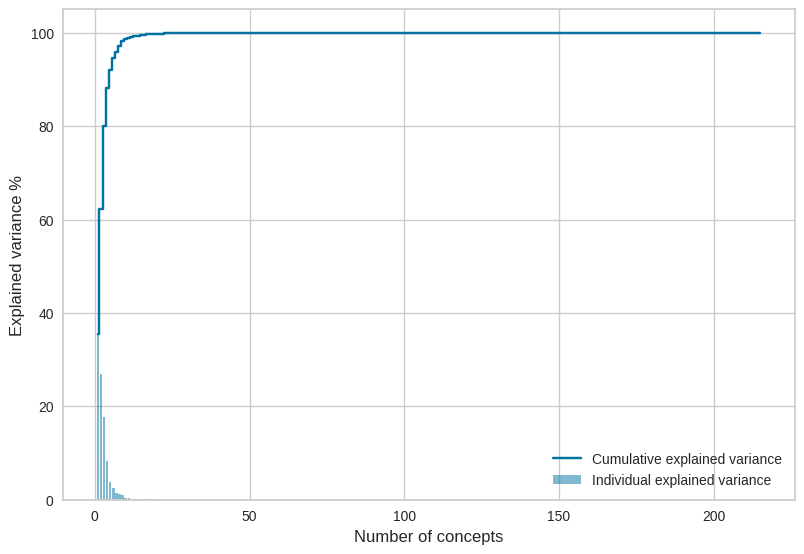

In [155]:
total_variance = np.sum(PCA_alg.explained_variance_ratio_)*100
print('The total explained variance using %i components is %.3f percent.' % (PCA_alg.n_components_, total_variance))

# Plotting explained variance with number of concepts [ / 4 marks]
exp_var_ratio = PCA_alg.explained_variance_ratio_
#
cum_sum_var = np.cumsum(exp_var_ratio)
#
# Create the visualization plot
#
plt.bar(range(1,len(exp_var_ratio)+1), exp_var_ratio*100, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1,len(cum_sum_var)+1), cum_sum_var*100, where='mid',label='Cumulative explained variance')
plt.legend(loc='best')
plt.tight_layout()

plt.xlabel('Number of concepts')
plt.ylabel('Explained variance %')
plt.show()

In [157]:
# To get the exact index where the variance is above 80%
id = np.argmax(cum_sum_var > 0.95)+1
print(f'The minimum number of components to get a variance above 95% is {id:.3f}, with a value of {cum_sum_var[id-1]*100:.3f}%')

The minimum number of components to get a variance above 95% is 7.000, with a value of 95.924%


In [179]:
# Get results
PCA_fit = PCA(n_components = 7)
psd_trans = PCA_fit.fit_transform(psd)
psd_trans.shape

(215, 7)

In [159]:
psd_trans[0:5,:]

array([[-0.14074509, -0.02664902, -0.0561183 ,  0.01197469, -0.00749442,
        -0.00992172,  0.03083393],
       [ 0.0280438 , -0.03692974,  0.03346342, -0.00306583,  0.04881153,
        -0.01782955, -0.00044453],
       [-0.15165401,  0.00396672,  0.02567139, -0.02141392,  0.04411643,
        -0.02711755,  0.02283554],
       [ 0.02416901, -0.03161881,  0.04247405,  0.02512284, -0.00219354,
        -0.02239949,  0.01462862],
       [-0.20883227,  0.00517243, -0.03535367,  0.01829304,  0.01933975,
        -0.01399212,  0.03607508]])

In [175]:
feature_names = [f'{k+1} component' for k in range(7)]
df_cluster = pd.DataFrame(data = psd_trans, columns = feature_names)
df_cluster.head()

1 component  2 component  3 component  4 component  5 component  \
0    -0.140745    -0.026649    -0.056118     0.011975    -0.007494   
1     0.028044    -0.036930     0.033463    -0.003066     0.048812   
2    -0.151654     0.003967     0.025671    -0.021414     0.044116   
3     0.024169    -0.031619     0.042474     0.025123    -0.002194   
4    -0.208832     0.005172    -0.035354     0.018293     0.019340   

   6 component  7 component  
0    -0.009922     0.030834  
1    -0.017830    -0.000445  
2    -0.027118     0.022836  
3    -0.022399     0.014629  
4    -0.013992     0.036075

In [176]:
# Create PCA with 3 features to visualize (preserves more than 80% of variance)
# Get results
PCA_vis = PCA(n_components = 3)
psd_vis = PCA_vis.fit_transform(psd)
psd_vis.shape

(215, 3)

In [177]:
features_plot = [f'{k+1} component' for k in range(3)]
df_plot = pd.DataFrame(data = psd_vis, columns = features_plot)
df_plot.head()

1 component  2 component  3 component
0    -0.140745    -0.026649    -0.056118
1     0.028044    -0.036930     0.033463
2    -0.151654     0.003967     0.025671
3     0.024169    -0.031619     0.042474
4    -0.208832     0.005172    -0.035354

In [178]:
fig = px.scatter_3d(df_plot, x='1 component', y='2 component', z='3 component')
fig.show()

#### ICA

#### T-SNE

In [202]:
# t-sne
tSNEmapper = TSNE(n_components=3,               # How many dimensions to use. Never more than 2 or 3
                  init='random',                # First initialization. Sparse matrices need 'random'.  Otherwise use 'pca'
                  perplexity=100.0,              # Read below
                  early_exaggeration=12.0,      # Read below
                  learning_rate='auto',         # Related to above. Leave to auto
                  n_iter=5000,                  # Very important to let iterate enough
                  n_iter_without_progress=300,  # Set early stopping
                  metric='euclidean',           # Metric to use to calculate distances.
                  min_grad_norm=1e-7,           # Minimum gradient to continue iterating
                  verbose=0,                    # Verbosity
                  random_state=42,              # Random seed
                  n_jobs=4,                     # Parallel processes
                 )

In [203]:
TSNE_embedding = tSNEmapper.fit_transform(psd)
TSNE_embedding.shape

(215, 3)

In [204]:
features_plot = [f'{k+1} component' for k in range(3)]
df_tsne = pd.DataFrame(data = TSNE_embedding, columns = features_plot)
df_tsne.head()

1 component  2 component  3 component
0    -0.191842     1.917877    -1.112530
1     0.007729    -0.573708    -0.089614
2    -0.204614     1.996497     0.032196
3     0.530890    -0.549898    -0.221679
4    -0.263030     2.581563    -0.649025

In [205]:
fig = px.scatter_3d(df_tsne, x='1 component', y='2 component', z='3 component')
fig.show()

#### UMAP

In [217]:
# UMAP
# Let's create the object
reducer = umap.UMAP(n_neighbors=15,              # Number of neareast neighbours to use. 
                    n_components=3,              # Number of components. UMAP is robust to larger values
                    metric='hellinger',          # Metric to use.
                    n_epochs=None,               # Iterations. Set to convergence. None implies either 200 or 500.
                    min_dist=0.1,                # Minimum distance embedded points. Smaller makes clumps, larger, sparseness.
                    spread=1.0,                  # Scale to combine with min_dist
                    low_memory=True,             # Run slower, but with less memory.
                    n_jobs=-1,                   # Cores to use
                    random_state=42,             # Random seed
                    verbose=True                 # Verbosity
                   )

# Now we train and calculate the embedding!
UMAP_embedding = reducer.fit_transform(psd)

UMAP(angular_rp_forest=True, metric='hellinger', n_components=3, random_state=42, verbose=True)
Sun May  7 15:59:22 2023 Construct fuzzy simplicial set
Sun May  7 15:59:22 2023 Finding Nearest Neighbors
Sun May  7 15:59:22 2023 Finished Nearest Neighbor Search
Sun May  7 15:59:22 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun May  7 15:59:24 2023 Finished embedding


In [218]:
features_plot = [f'{k+1} component' for k in range(3)]
df_umap = pd.DataFrame(data = UMAP_embedding, columns = features_plot)
df_umap.head()

1 component  2 component  3 component
0     6.952110    12.947666     5.264738
1     3.253861    12.920189     8.809564
2     6.817919    12.620558     6.103841
3     2.564634    13.162175     9.357441
4     6.793734    12.750922     6.027906

In [219]:
fig = px.scatter_3d(df_umap, x='1 component', y='2 component', z='3 component')
fig.show()

**Summary visualization:**
- PCA does quite well. No need for UMAP or T-SNE

### Clustering

#### K-means

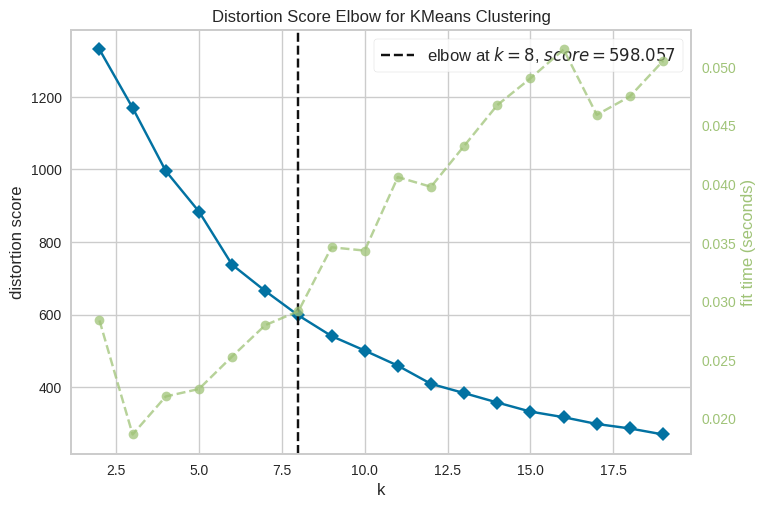

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [182]:
# Based on the plot, there are probably 2-4 clusters
# Initialize the object
# Initializing the cluster algorithm
scaler = StandardScaler()
scaled_data = scaler.fit_transform(psd_trans)
KClusterer = KMeans(n_clusters=3) # Name of operator and cluster number

visualizer = KElbowVisualizer(KClusterer, # Cluster model with any parameters you need
                              k=(2,20),   # Number of clusters to test (2 to 12 in this case)
                              locate_elbow=True, # Locate the elbow? Default is true.
                              timings=True # Plot the timings to train?
                             )   

visualizer.fit(scaled_data)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

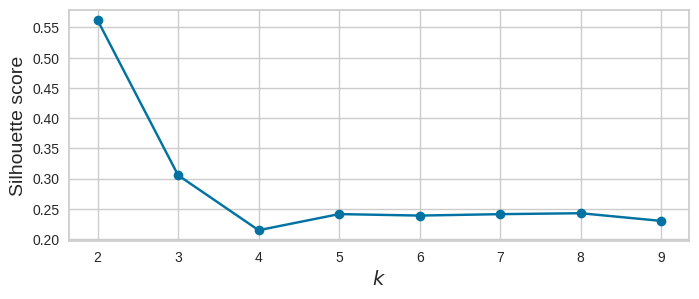

In [183]:
# silhouette_score
from sklearn.metrics import silhouette_score
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(scaled_data) for k in range(2, 10)]

silhouette_scores = [silhouette_score(scaled_data, model.labels_) for model in kmeans_per_k]

plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
# plt.axis([1.8, 8.5, 0.55, 0.7])
plt.show()

In [184]:
# Initializing the cluster algorithm
kmeans_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('kmeans', KMeans(n_clusters=8))
])

kmeans_pipe.fit(psd_trans)
df_cluster['cluster_label_scaled'] = kmeans_pipe.predict(psd_trans)
df_plot['cluster_label_scaled'] = kmeans_pipe.predict(psd_trans)

In [185]:
fig = px.scatter_3d(df_plot, x='1 component', y='2 component', z='3 component', color = 'cluster_label_scaled')
fig.show()

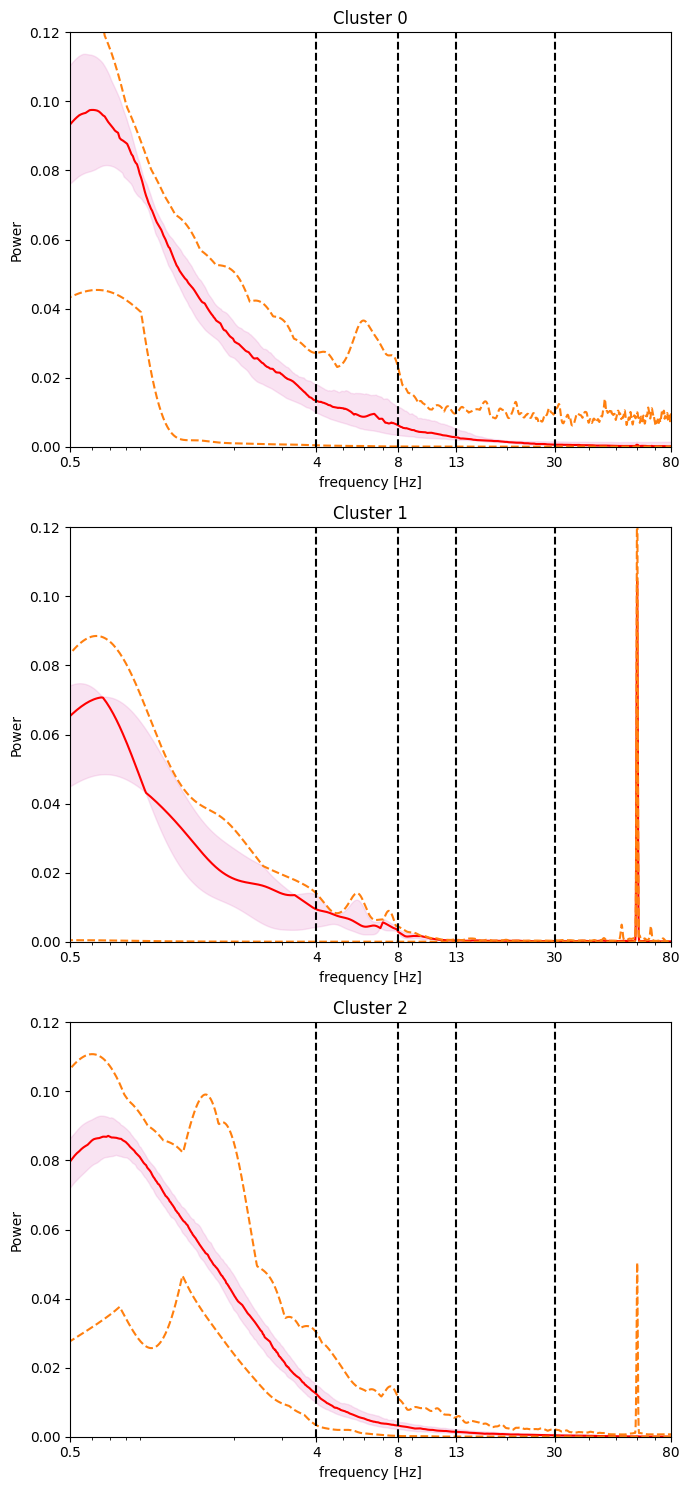

In [43]:
# Visualize
# First component
kmeans_comp1_idx = df_plot.loc[df_plot['cluster_label_scaled']==0, ['1 component', '2 component', '3 component']].index
kmeans_psd1 = psd[kmeans_comp1_idx, :]
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(7,15))
plotPaperFigures(f[0], kmeans_psd1, show_fig=False, ax=axs[0])
axs[0].set_title('Cluster 0')
# Second component
kmeans_comp2_idx = df_plot.loc[df_plot['cluster_label_scaled']==1, ['1 component', '2 component', '3 component']].index
kmeans_psd2 = psd[kmeans_comp2_idx, :]
plotPaperFigures(f[0], kmeans_psd2, show_fig=False, ax=axs[1])
axs[1].set_title('Cluster 1')
# Third component
kmeans_comp3_idx = df_plot.loc[df_plot['cluster_label_scaled']==2, ['1 component', '2 component', '3 component']].index
kmeans_psd3 = psd[kmeans_comp3_idx, :]
plotPaperFigures(f[0], kmeans_psd3, show_fig=False, ax=axs[2])
axs[2].set_title('Cluster 2')
plt.tight_layout()

Text(0.5, 1.0, 'Cluster 2')

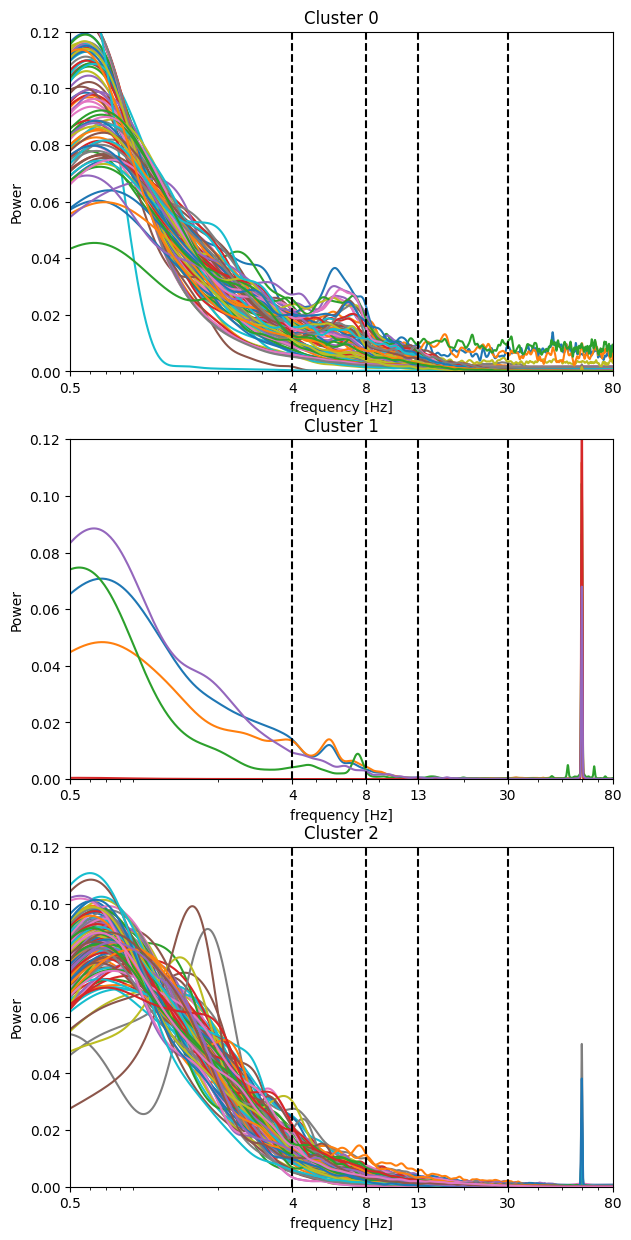

In [ ]:
# First component
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(7,15))
plotAllChannels(f[kmeans_comp1_idx, :].T, kmeans_psd1.T, show_fig=False, ax=axs[0])
axs[0].set_title('Cluster 0')
# Second component
plotAllChannels(f[kmeans_comp2_idx, :].T, kmeans_psd2.T, show_fig=False, ax=axs[1])
axs[1].set_title('Cluster 1')
# Third component
plotAllChannels(f[kmeans_comp3_idx, :].T, kmeans_psd3.T, show_fig=False, ax=axs[2])
axs[2].set_title('Cluster 2')

#### Agglomerative clustering


In [61]:
# Agglomerative clustering
acl_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('aggcl', AgglomerativeClustering(n_clusters=2, linkage="single"))
])

df_plot['aggcl_label_scaled'] = acl_pipe.fit_predict(psd_trans)

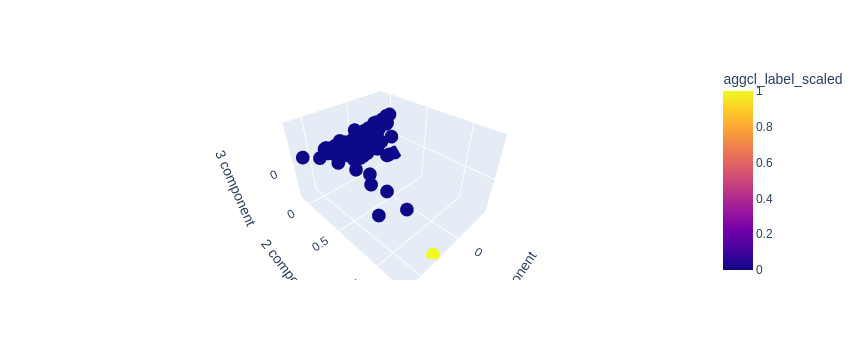

In [62]:
fig = px.scatter_3d(df_plot, x='1 component', y='2 component', z='3 component', color = 'aggcl_label_scaled')
fig.show()
# Not great

#### DBSCAN

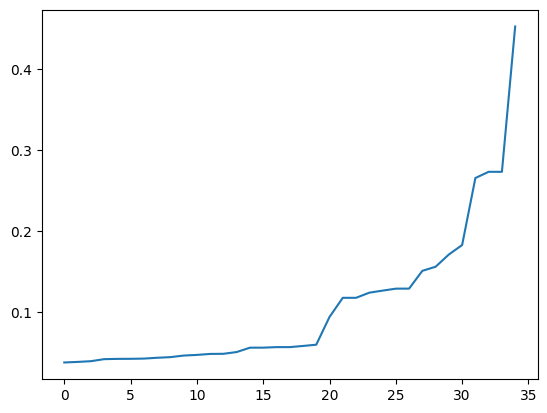

In [63]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(psd_trans)
distances, indices = nbrs.kneighbors(psd_trans)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances[180:])

In [64]:
# DBSCAN
dbscan_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('dbscan', DBSCAN(eps=0.5))
])
df_plot['dbscan_label_scaled'] = dbscan_pipe.fit_predict(psd_trans)

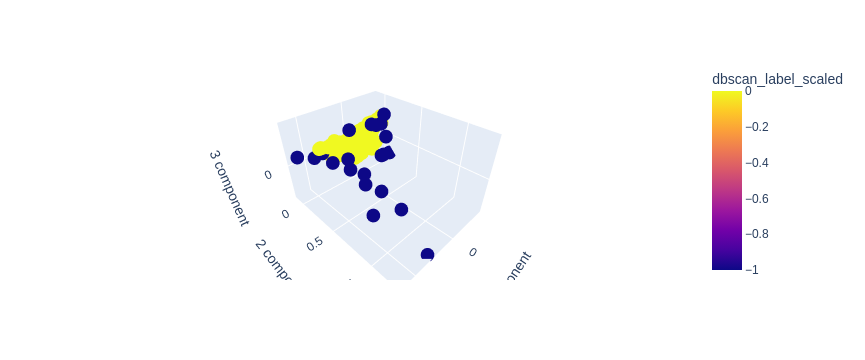

In [65]:
fig = px.scatter_3d(df_plot, x='1 component', y='2 component', z='3 component', color = 'dbscan_label_scaled')
fig.show()

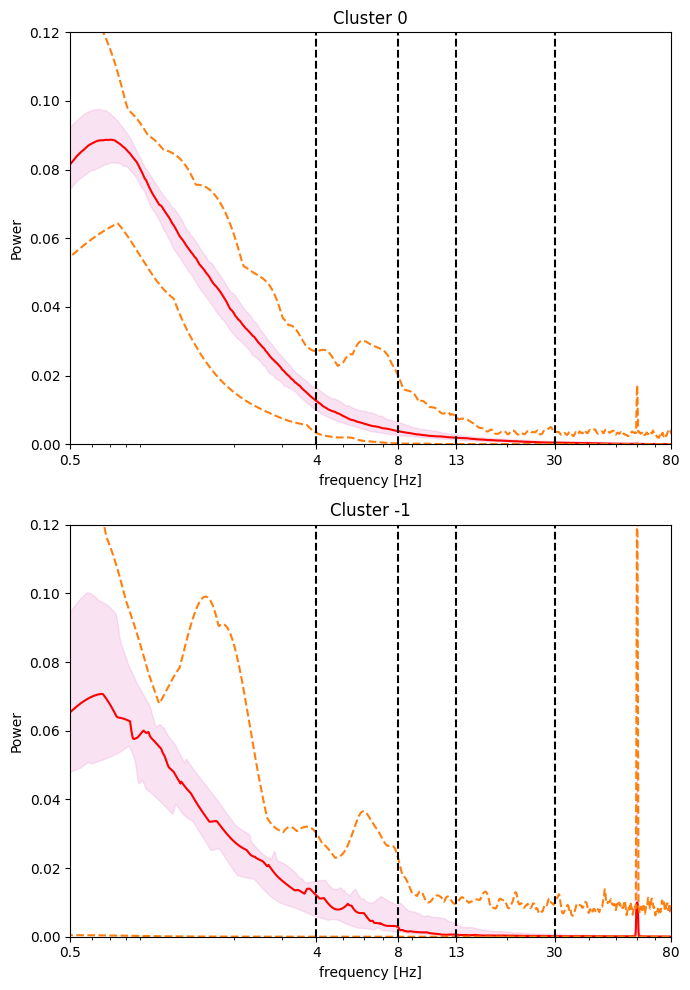

In [68]:
# Visualize
# First component
clutering_type = 'dbscan_label_scaled'
comp1_idx = df_plot.loc[df_plot[clutering_type]==0, ['1 component', '2 component', '3 component']].index
psd1 = psd[comp1_idx, :]
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7,10))
plotPaperFigures(f[0], psd1, show_fig=False, ax=axs[0])
axs[0].set_title('Cluster 0')
# Second component
comp2_idx = df_plot.loc[df_plot[clutering_type]==-1, ['1 component', '2 component', '3 component']].index
psd2 = psd[comp2_idx, :]
plotPaperFigures(f[0], psd2, show_fig=False, ax=axs[1])
axs[1].set_title('Cluster -1')
plt.tight_layout()

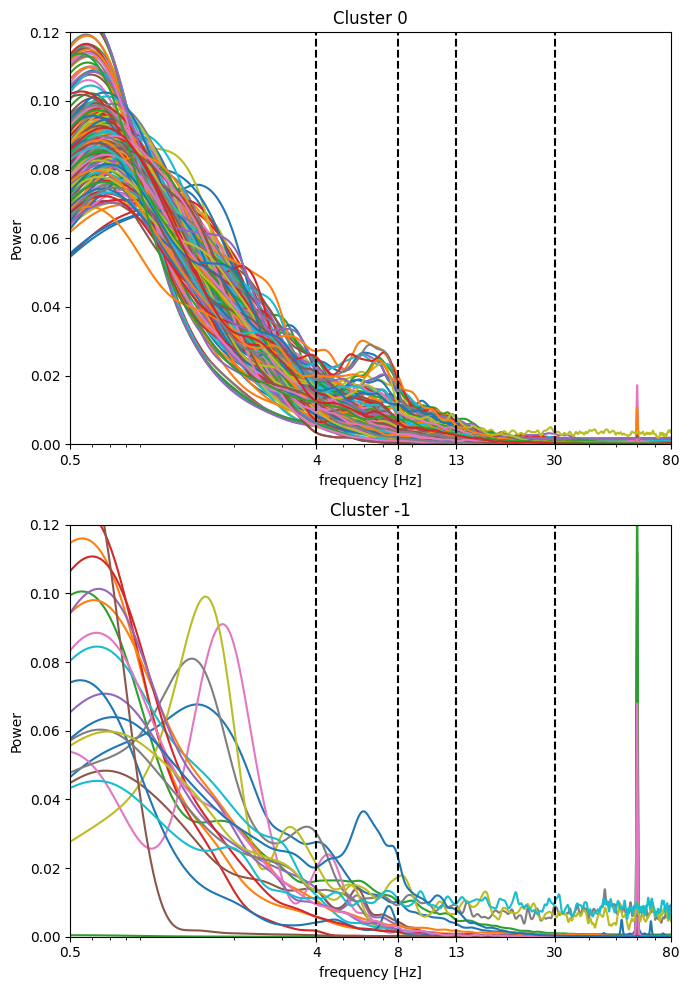

In [71]:
# First component
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7,10))
plotAllChannels(f[comp1_idx, :].T, psd1.T, show_fig=False, ax=axs[0])
axs[0].set_title('Cluster 0')
# Second component
plotAllChannels(f[comp2_idx, :].T, psd2.T, show_fig=False, ax=axs[1])
axs[1].set_title('Cluster -1')
plt.tight_layout()

This is actually quite good!!

#### GMM

In [151]:
# GMM
gmm_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('gm', GaussianMixture(n_components=3, random_state=10))
])
df_plot['gmm_label_scaled'] = gmm_pipe.fit_predict(psd_trans)

In [152]:
fig = px.scatter_3d(df_plot, x='1 component', y='2 component', z='3 component', color = 'gmm_label_scaled')
fig.show()

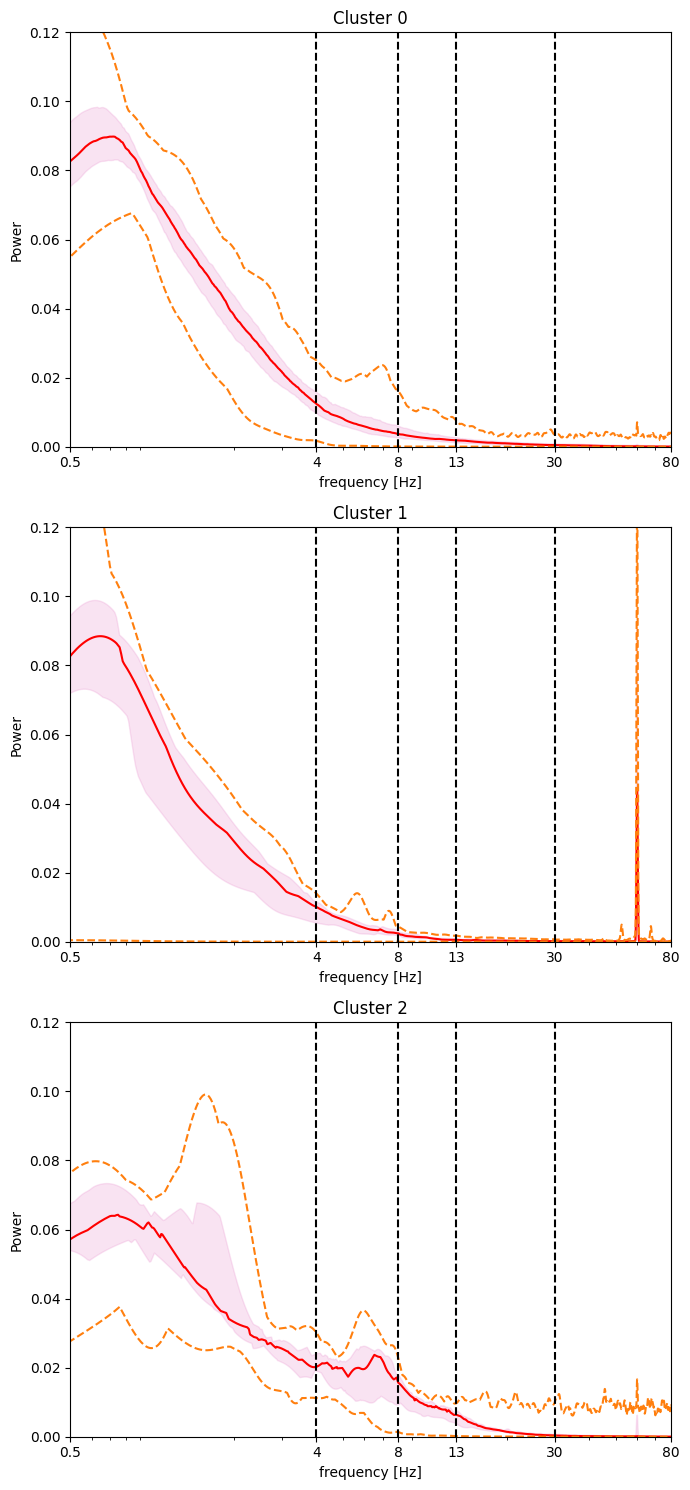

In [78]:
# Visualize
# First component
clutering_type = 'gmm_label_scaled'
comp1_idx = df_plot.loc[df_plot[clutering_type]==0, ['1 component', '2 component', '3 component']].index
psd1 = psd[comp1_idx, :]
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(7,15))
plotPaperFigures(f[0], psd1, show_fig=False, ax=axs[0])
axs[0].set_title('Cluster 0')
# Second component
comp2_idx = df_plot.loc[df_plot[clutering_type]==1, ['1 component', '2 component', '3 component']].index
psd2 = psd[comp2_idx, :]
plotPaperFigures(f[0], psd2, show_fig=False, ax=axs[1])
axs[1].set_title('Cluster 1')
# Third component
comp3_idx = df_plot.loc[df_plot[clutering_type]==2, ['1 component', '2 component', '3 component']].index
psd3 = psd[comp3_idx, :]
plotPaperFigures(f[0], psd3, show_fig=False, ax=axs[2])
axs[2].set_title('Cluster 2')
plt.tight_layout()

Text(0.5, 1.0, 'Cluster 2')

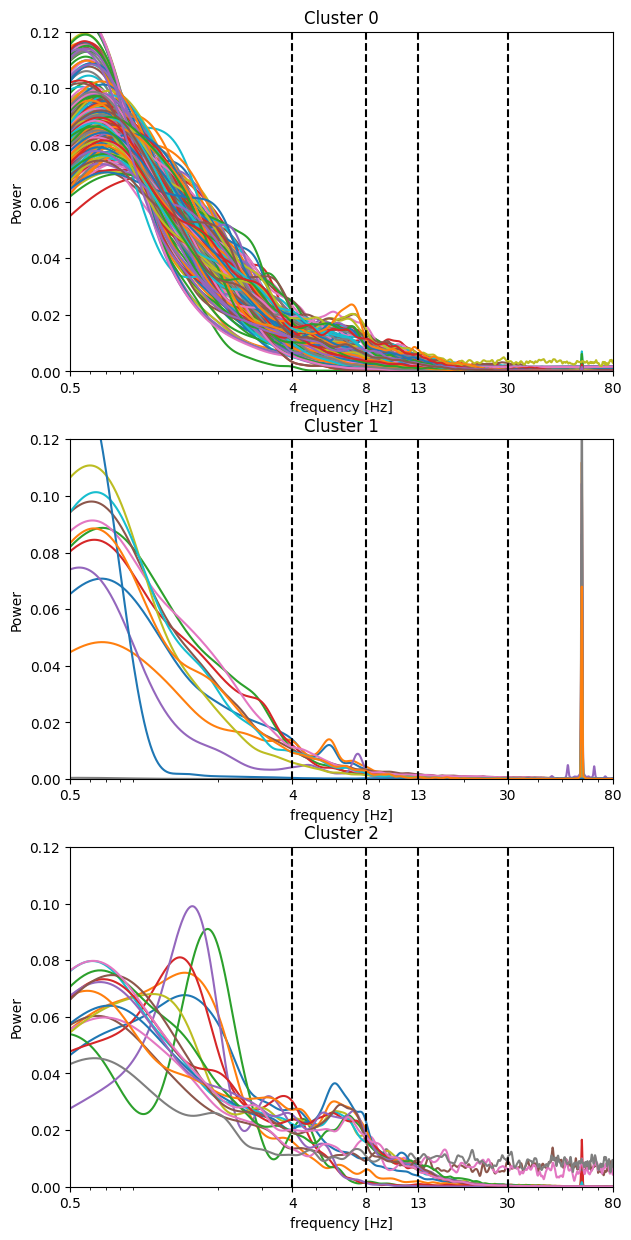

In [79]:
# First component
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(7,15))
plotAllChannels(f[comp1_idx, :].T, psd1.T, show_fig=False, ax=axs[0])
axs[0].set_title('Cluster 0')
# Second component
plotAllChannels(f[comp2_idx, :].T, psd2.T, show_fig=False, ax=axs[1])
axs[1].set_title('Cluster 1')
# Third component
plotAllChannels(f[comp3_idx, :].T, psd3.T, show_fig=False, ax=axs[2])
axs[2].set_title('Cluster 2')

**Summary:**
- K-Means does poorly.
- Agglomerative clustering doesn't perform well.
- DBSCAN does way better but still can see some probably abnormal peaks in the theta band.
- GMM is the best, which identifies two abnormal clusters: one related to PLI and the other more related to abnormalities in delta and theta bands.

### Using means per band

In [16]:
freq_bands = [0,4,8,13,30,80]
freq_names = ['Mean Delta','Mean Theta','Mean Alpha', 'Mean Beta', 'Mean Gamma']
for i in range(len(freq_bands)-1):
    idx0 = np.argmin(np.abs(f[0]-freq_bands[i]))
    idx1 = np.argmin(np.abs(f[0]-freq_bands[i+1]))
    df_plot[freq_names[i]] = np.mean(psd, axis=1)

In [17]:
df_plot.head()

1 component  2 component  3 component  Mean Delta  Mean Theta  Mean Alpha  \
0    -0.140745    -0.026649    -0.056118    0.002480    0.002480    0.002480   
1     0.028044    -0.036930     0.033463    0.002844    0.002844    0.002844   
2    -0.151654     0.003967     0.025671    0.002814    0.002814    0.002814   
3     0.024169    -0.031619     0.042474    0.003089    0.003089    0.003089   
4    -0.208832     0.005172    -0.035354    0.002730    0.002730    0.002730   

   Mean Beta  Mean Gamma  
0   0.002480    0.002480  
1   0.002844    0.002844  
2   0.002814    0.002814  
3   0.003089    0.003089  
4   0.002730    0.002730

In [18]:
# Cluster based on means
means_array = df_plot[freq_names].to_numpy()
PCA_alg = PCA()
PCA_alg.fit(means_array)

PCA()

The total explained variance using 5 components is 100.000 percent.


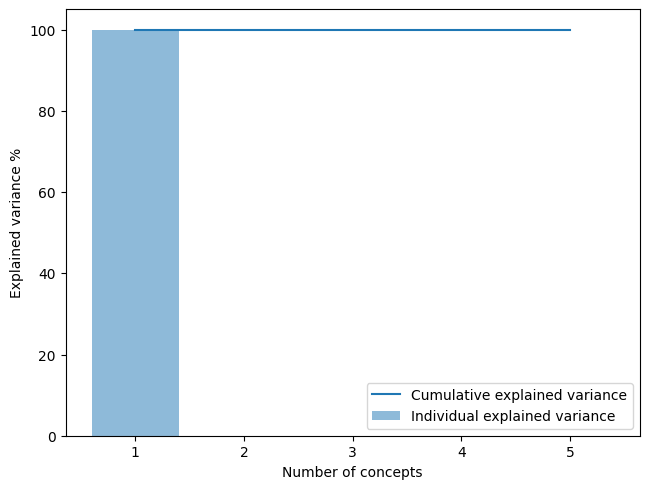

In [19]:
total_variance = np.sum(PCA_alg.explained_variance_ratio_)*100
print('The total explained variance using %i components is %.3f percent.' % (PCA_alg.n_components_, total_variance))

# Plotting explained variance with number of concepts [ / 4 marks]
exp_var_ratio = PCA_alg.explained_variance_ratio_
#
cum_sum_var = np.cumsum(exp_var_ratio)
#
# Create the visualization plot
#
plt.bar(range(1,len(exp_var_ratio)+1), exp_var_ratio*100, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1,len(cum_sum_var)+1), cum_sum_var*100, where='mid',label='Cumulative explained variance')
plt.legend(loc='best')
plt.tight_layout()

plt.xlabel('Number of concepts')
plt.ylabel('Explained variance %')
plt.show()

In [20]:
# To get the exact index where the variance is above 80%
id = np.argmax(cum_sum_var > 0.8)+1
print(f'The minimum number of components to get a variance above 80% is {id:.3f}, with a value of {cum_sum_var[id-1]*100:.3f}%')

The minimum number of components to get a variance above 80% is 1.000, with a value of 100.000%


In [40]:
# Get results using 2 components
PCA_fit = PCA(n_components = 3)
means_trans = PCA_fit.fit_transform(means_array)
means_trans.shape

(215, 3)

In [42]:
df_plot['Comp1 Means'] = means_trans[:,0]
df_plot['Comp2 Means'] = means_trans[:,1]
df_plot['Comp3 Means'] = means_trans[:,2]

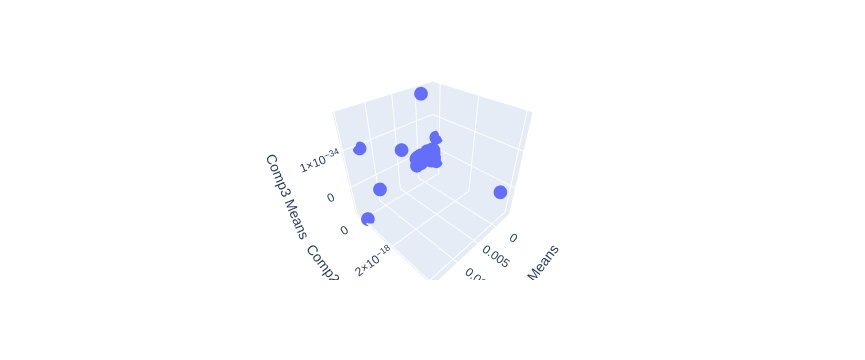

In [43]:
fig = px.scatter_3d(df_plot, x='Comp1 Means', y='Comp2 Means', z='Comp3 Means')
fig.show()

#### Using K-means

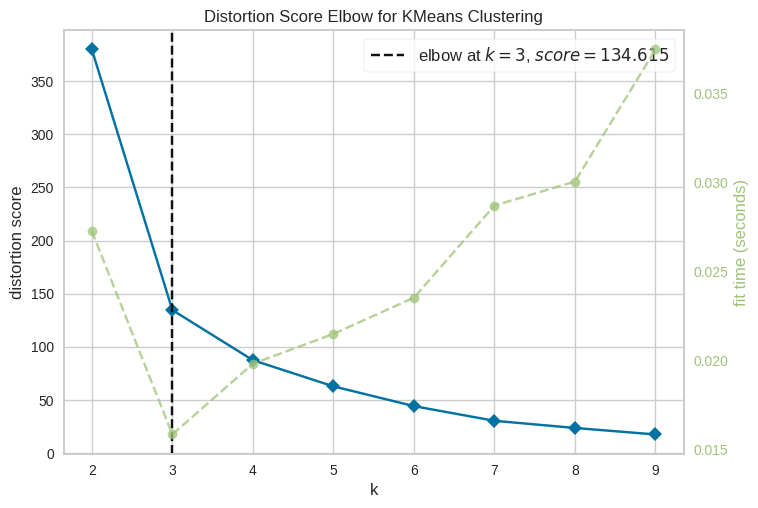

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [112]:
# Based on the plot, there are probably 2-4 clusters
# Initialize the object
# Initializing the cluster algorithm
scaler = StandardScaler()
scaled_data = scaler.fit_transform(means_array)
KClusterer = KMeans(n_clusters=3) # Name of operator and cluster number

visualizer = KElbowVisualizer(KClusterer, # Cluster model with any parameters you need
                              k=(2,10),   # Number of clusters to test (2 to 12 in this case)
                              locate_elbow=True, # Locate the elbow? Default is true.
                              timings=True # Plot the timings to train?
                             )   

visualizer.fit(scaled_data)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

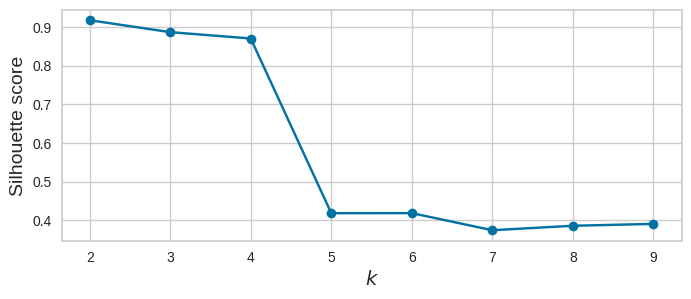

In [103]:
# silhouette_score
from sklearn.metrics import silhouette_score
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(scaled_data) for k in range(2, 10)]

silhouette_scores = [silhouette_score(scaled_data, model.labels_) for model in kmeans_per_k]

plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
# plt.axis([1.8, 8.5, 0.55, 0.7])
plt.show()

In [113]:
kmeans_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('kmeans', KMeans(n_clusters=3))
])
df_plot['kmeans_means'] = kmeans_pipe.fit_predict(means_array)

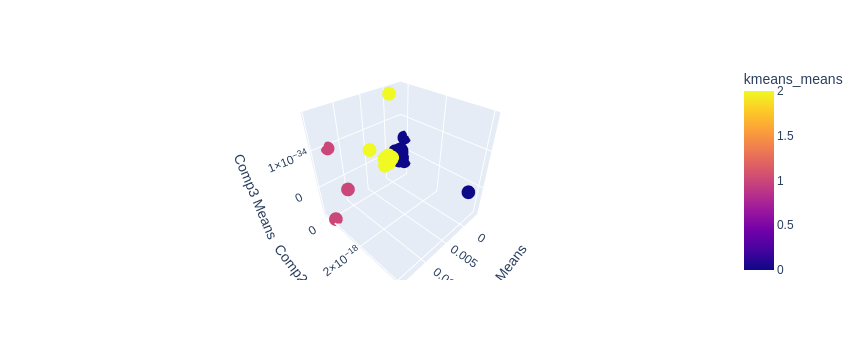

In [114]:
fig = px.scatter_3d(df_plot, x='Comp1 Means', y='Comp2 Means', z='Comp3 Means', color='kmeans_means')
fig.show()

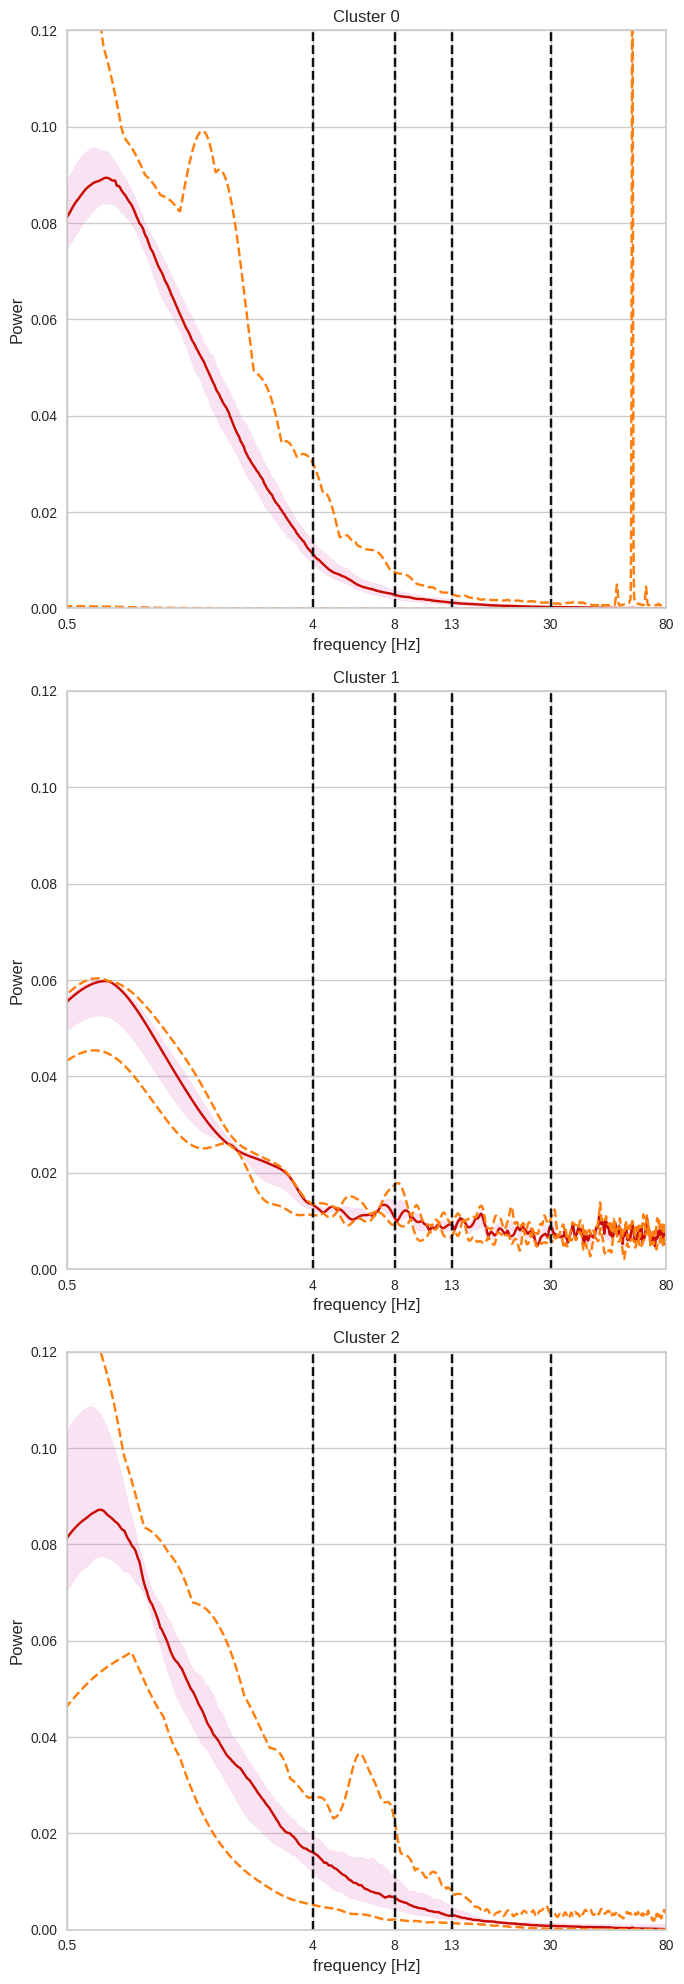

In [115]:
# Visualize
# First component
clutering_type = 'kmeans_means'
comp1_idx = df_plot.loc[df_plot[clutering_type]==0].index
psd1 = psd[comp1_idx, :]
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(7,20))
plotPaperFigures(f[0], psd1, show_fig=False, ax=axs[0])
axs[0].set_title('Cluster 0')
# Second component
comp2_idx = df_plot.loc[df_plot[clutering_type]==1].index
psd2 = psd[comp2_idx, :]
plotPaperFigures(f[0], psd2, show_fig=False, ax=axs[1])
axs[1].set_title('Cluster 1')
# Third component
comp3_idx = df_plot.loc[df_plot[clutering_type]==2].index
psd3 = psd[comp3_idx, :]
plotPaperFigures(f[0], psd3, show_fig=False, ax=axs[2])
axs[2].set_title('Cluster 2')
# # Fourth component
# comp4_idx = df_plot.loc[df_plot[clutering_type]==3].index
# psd4 = psd[comp4_idx, :]
# plotPaperFigures(f[0], psd4, show_fig=False, ax=axs[3])
# axs[3].set_title('Cluster 3')
plt.tight_layout()

Not great with all the features nor PCA components.

#### Agglomerative clustering

In [120]:
# Agglomerative clustering
acl_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('aggcl', AgglomerativeClustering(n_clusters=3, linkage="single"))
])

df_plot['aggcl_means'] = acl_pipe.fit_predict(means_array)

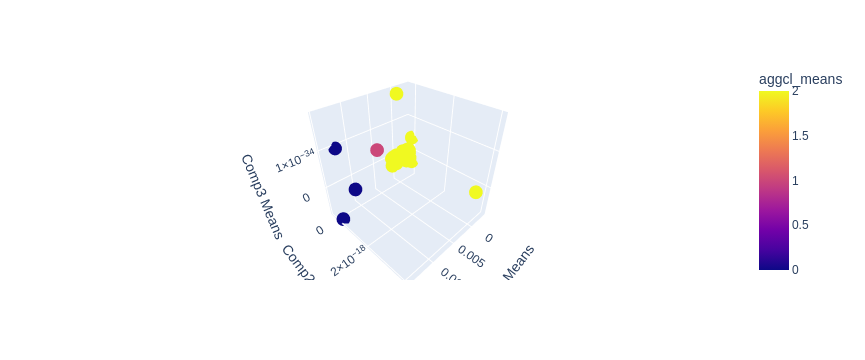

In [121]:
fig = px.scatter_3d(df_plot, x='Comp1 Means', y='Comp2 Means', z='Comp3 Means', color='aggcl_means')
fig.show()

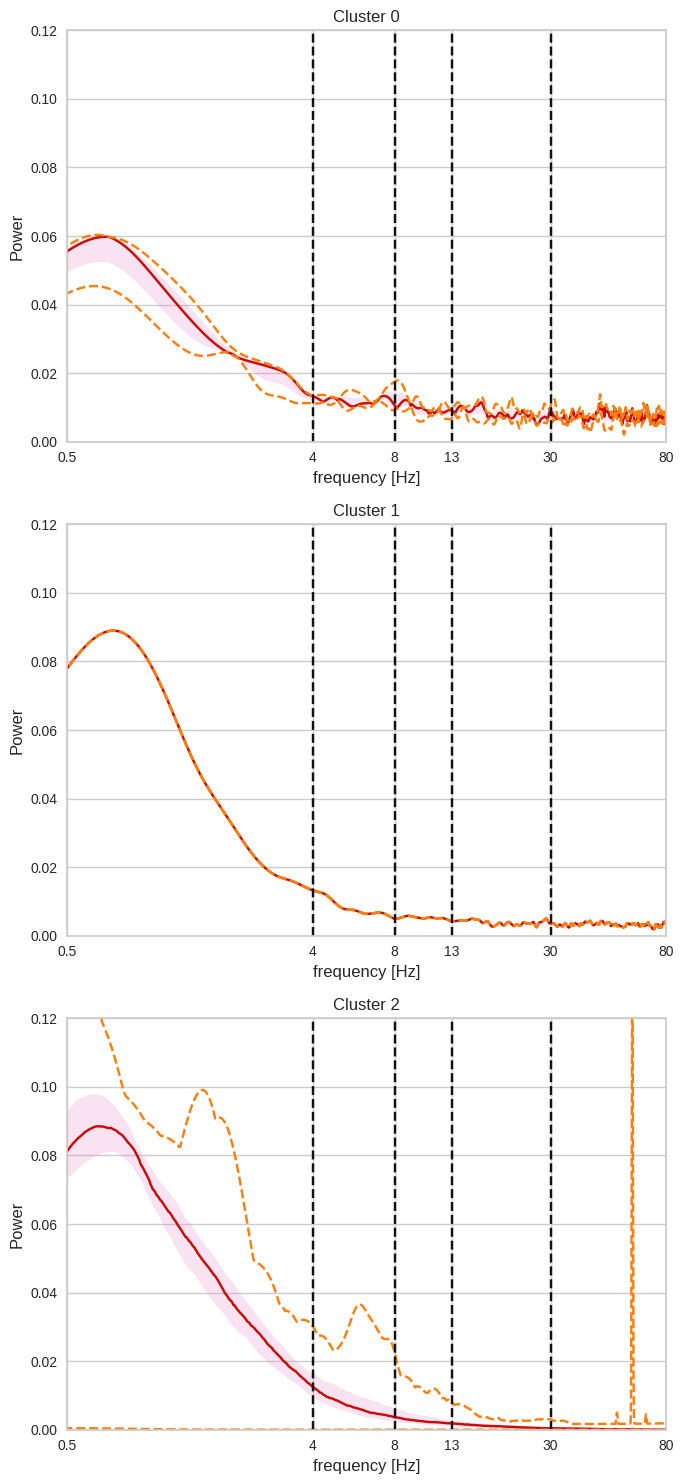

In [128]:
# Visualize
# First component
clutering_type = 'aggcl_means'
comp1_idx = df_plot.loc[df_plot[clutering_type]==0].index
psd1 = psd[comp1_idx, :]
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(7,15))
plotPaperFigures(f[0], psd1, show_fig=False, ax=axs[0])
axs[0].set_title('Cluster 0')
# Second component
comp2_idx = df_plot.loc[df_plot[clutering_type]==1].index
psd2 = psd[comp2_idx, :]
plotPaperFigures(f[0], psd2, show_fig=False, ax=axs[1])
axs[1].set_title('Cluster 1')
# Third component
comp3_idx = df_plot.loc[df_plot[clutering_type]==2].index
psd3 = psd[comp3_idx, :]
plotPaperFigures(f[0], psd3, show_fig=False, ax=axs[2])
axs[2].set_title('Cluster 2')
plt.tight_layout()

Again, not amazing

#### DBSCAN

In [123]:
# DBSCAN
dbscan_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('dbscan', DBSCAN(eps=0.5))
])
df_plot['dbscan_means'] = dbscan_pipe.fit_predict(means_array)

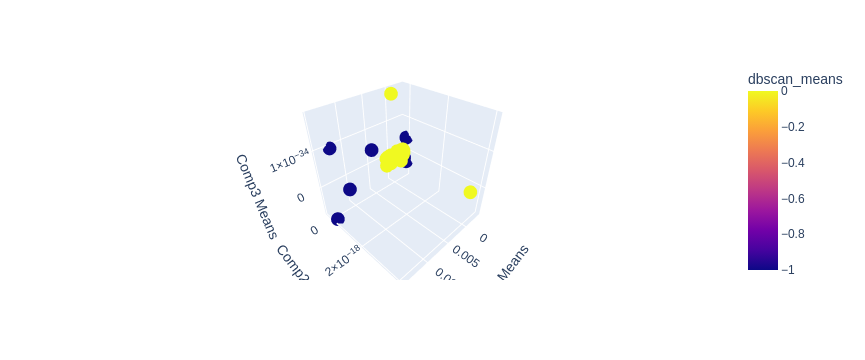

In [124]:
fig = px.scatter_3d(df_plot, x='Comp1 Means', y='Comp2 Means', z='Comp3 Means', color='dbscan_means')
fig.show()

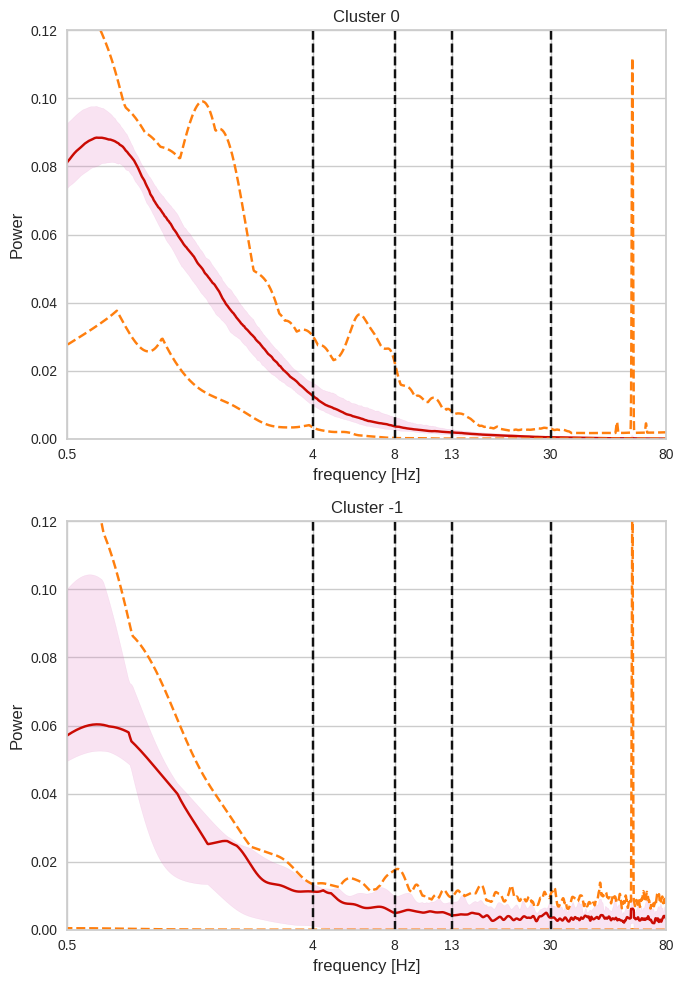

In [127]:
# Visualize
# First component
clutering_type = 'dbscan_means'
comp1_idx = df_plot.loc[df_plot[clutering_type]==0].index
psd1 = psd[comp1_idx, :]
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7,10))
plotPaperFigures(f[0], psd1, show_fig=False, ax=axs[0])
axs[0].set_title('Cluster 0')
# Second component
comp2_idx = df_plot.loc[df_plot[clutering_type]==-1].index
psd2 = psd[comp2_idx, :]
plotPaperFigures(f[0], psd2, show_fig=False, ax=axs[1])
axs[1].set_title('Cluster -1')
plt.tight_layout()

Better with full spectrum

#### GMM

In [146]:
# GMM
gmm_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('gm', GaussianMixture(n_components=3, random_state=10))
])
df_plot['gmm_means'] = gmm_pipe.fit_predict(means_array)

In [147]:
fig = px.scatter_3d(df_plot, x='Comp1 Means', y='Comp2 Means', z='Comp3 Means', color='gmm_means')
fig.show()

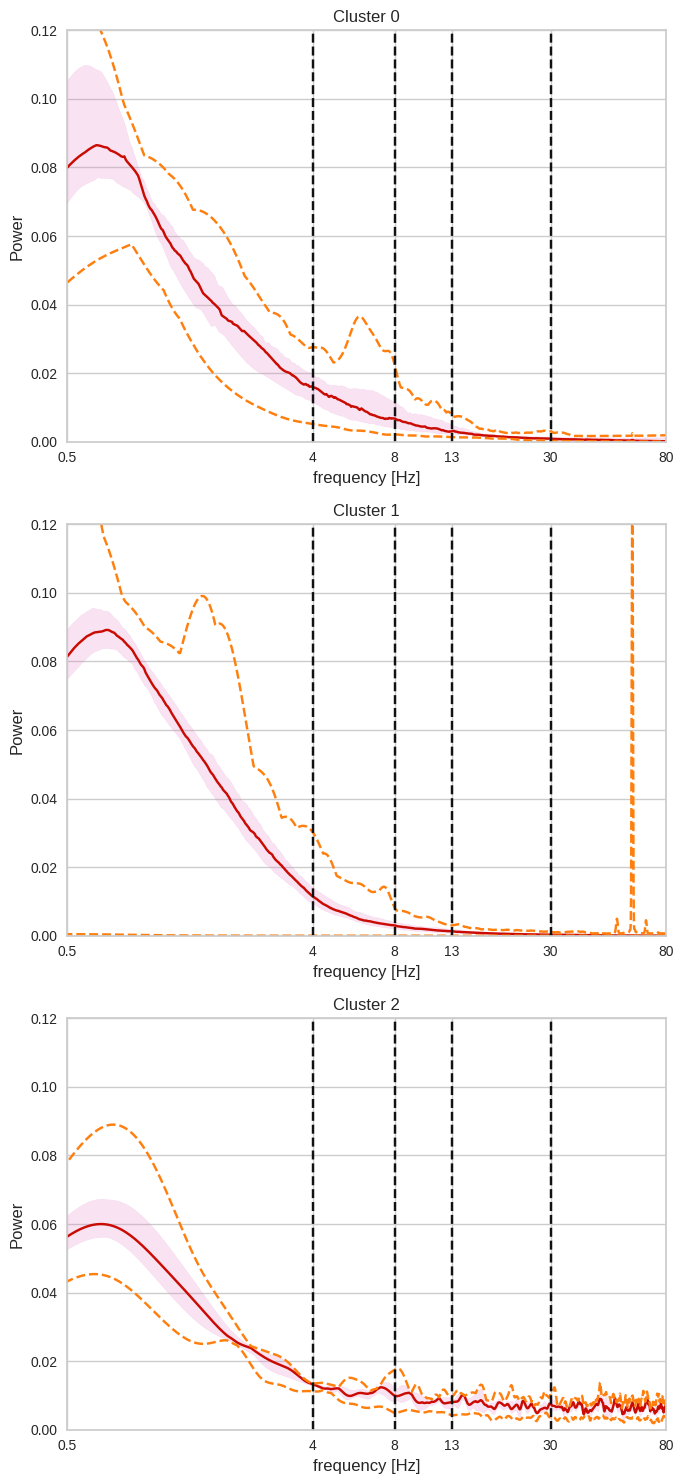

In [149]:
# Visualize
# First component
clutering_type = 'gmm_means'
comp1_idx = df_plot.loc[df_plot[clutering_type]==0].index
psd1 = psd[comp1_idx, :]
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(7,15))
plotPaperFigures(f[0], psd1, show_fig=False, ax=axs[0])
axs[0].set_title('Cluster 0')
# Second component
comp2_idx = df_plot.loc[df_plot[clutering_type]==1].index
psd2 = psd[comp2_idx, :]
plotPaperFigures(f[0], psd2, show_fig=False, ax=axs[1])
axs[1].set_title('Cluster 1')
# Third component
comp3_idx = df_plot.loc[df_plot[clutering_type]==2].index
psd3 = psd[comp3_idx, :]
plotPaperFigures(f[0], psd3, show_fig=False, ax=axs[2])
axs[2].set_title('Cluster 2')
plt.tight_layout()

Still better with full spectrum